In [1]:
#Importing all the necessary libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler

In [3]:
#Loading the csv file of TATAMOTORS
import os


df = pd.read_csv(os.path.join('c:' + os.sep, 'Users', 'Supreet Patel', 'OneDrive','Desktop','STOCK DETAILS','TATAMOTORS.csv'))

In [4]:
df.head()


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,TELCO,EQ,201.60,207.4,217.25,207.4,217.0,216.75,214.28,676126,1.448775e+13,NaN,NaN,NaN
1,2000-01-04,TELCO,EQ,216.75,217.0,219.00,206.0,211.9,208.20,209.50,679215,1.422962e+13,NaN,NaN,NaN
2,2000-01-05,TELCO,EQ,208.20,194.0,217.80,194.0,213.1,213.25,210.33,1120951,2.357684e+13,NaN,NaN,NaN
3,2000-01-06,TELCO,EQ,213.25,215.0,229.90,215.0,222.0,222.10,225.29,1968998,4.435932e+13,NaN,NaN,NaN
4,2000-01-07,TELCO,EQ,222.10,224.0,239.90,223.1,239.9,239.90,236.32,2199431,5.197636e+13,NaN,NaN,NaN


In [5]:
df.shape

(5306, 15)

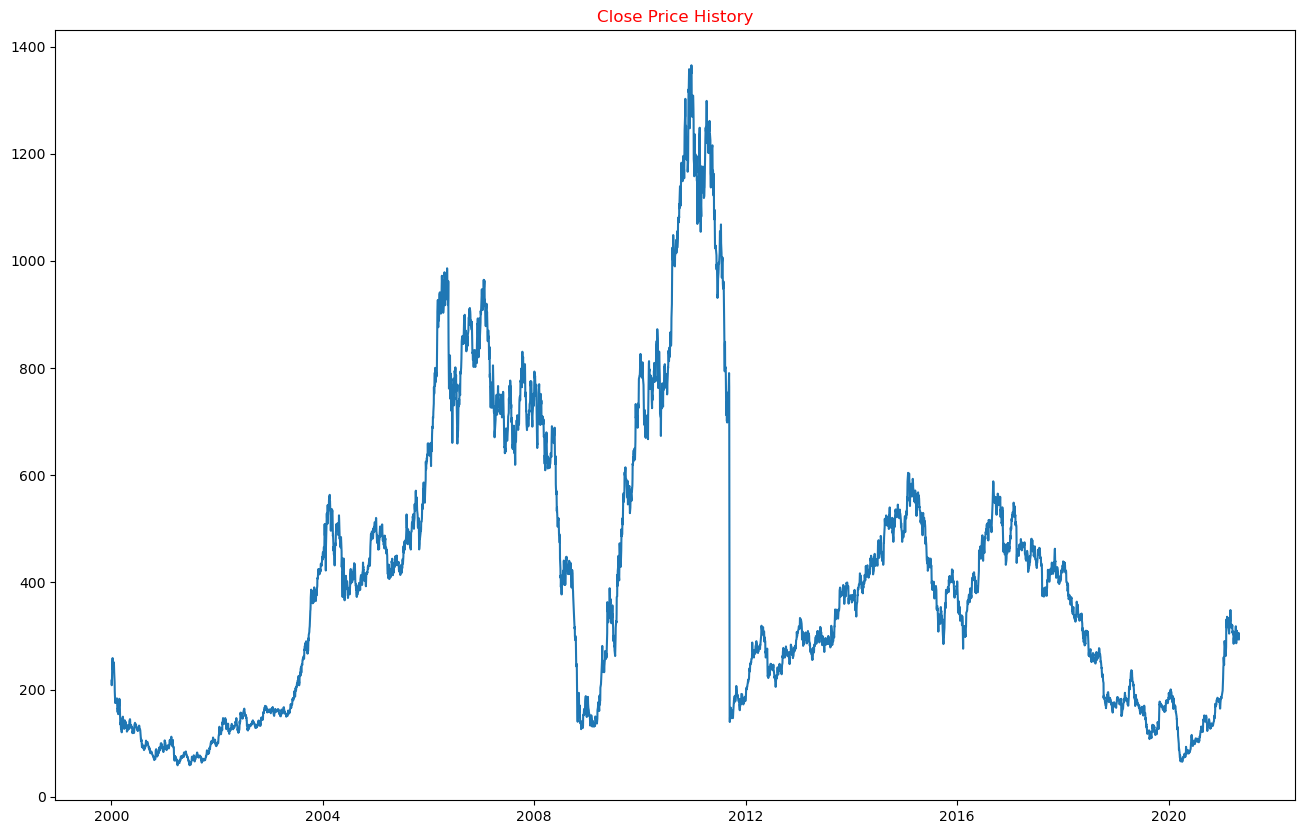

In [6]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,10))
plt.title("Close Price History",color='red')
plt.plot(df["Close"])

In [7]:
data=df.sort_index(ascending=True,axis=0)
#creating the new dataset
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [8]:
df.shape

(5306, 15)

In [9]:
scaler=MinMaxScaler(feature_range=(0,1))

final_dataset=new_dataset.values
#creating the train_data
train_data=final_dataset[0:4000,:]
#creating the valid data
valid_data=final_dataset[4000:,:]

final_dataset=new_dataset.values

scaler = MinMaxScaler(feature_range=(0, 1))


scaled_data = scaler.fit_transform(final_dataset[:, 1:])

x_train_data, y_train_data = [], []
for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i-60:i, 0])
    y_train_data.append(scaled_data[i, 0])
    
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

# Reshaping x_train_data
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))


In [10]:
#using the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))


inputs_data = new_dataset[len(new_dataset) - len(valid_data) - 60:].iloc[:, 1:].values
inputs_data = inputs_data.reshape(-1, 1)
inputs_data = scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train_data, y_train_data, epochs=1, batch_size=1, verbose=2)


3940/3940 - 119s - loss: 0.0011 - 119s/epoch - 30ms/step


In [12]:
X_test=[] #creating an empty X_test
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0]) #appending the data to the X_test
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

41/41 [==============================] - 3s 25ms/step


C:\Users\Supreet Patel\AppData\Local\Temp\ipykernel_20540\502748872.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


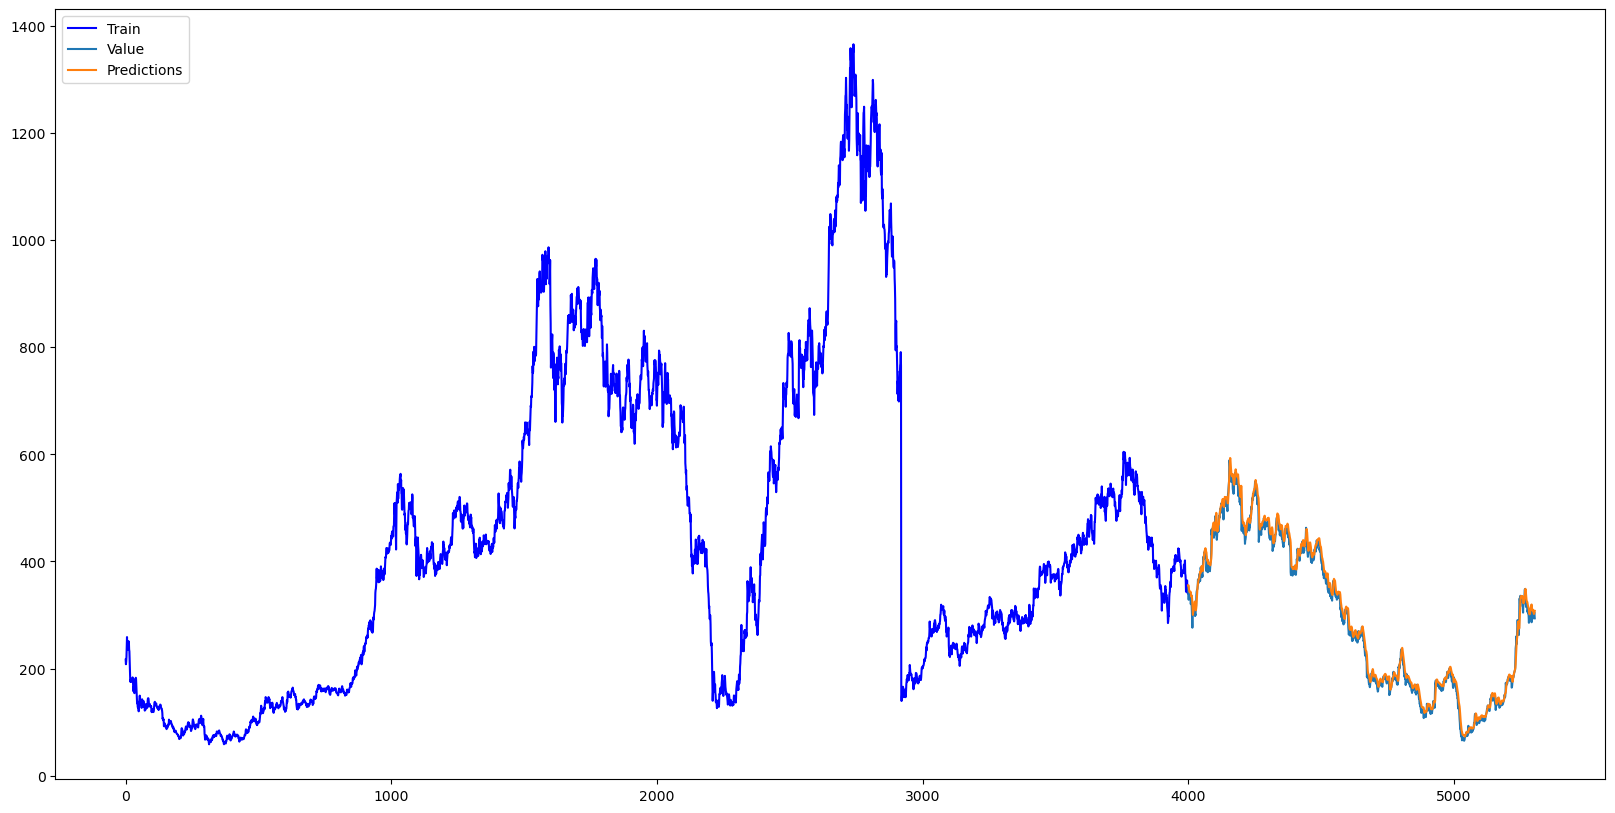

In [13]:
train_data=new_dataset[:4000]
valid_data=new_dataset[4000:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"],color='blue',label='Actual Stock Price')
plt.plot(valid_data[['Close',"Predictions"]])
plt.legend(['Train','Value','Predictions'],loc='upper left')
plt.show()